In [1]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

import monai
from monai import transforms

from utils.utils import adjust_window, visualize, print_info

In [2]:
data_dict = {
    'image': '../data/ID_c9d6fdc6_ID_7f09be285d.nii.gz',
    'label': '../data/ID_c9d6fdc6_ID_7f09be285d-ich_seg.nii.gz'
}

In [3]:
# 数据读取
io_transform = transforms.LoadImaged(keys=["image", "label"])
data = io_transform(data_dict)
print_info(data)

image shape: torch.Size([512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


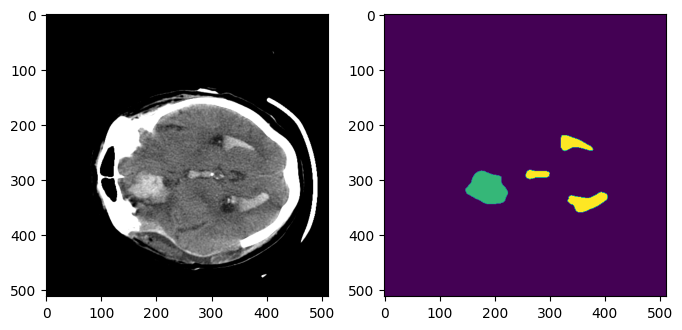

In [4]:
visualize(data)

In [5]:
# 添加channel维度
transform = transforms.EnsureChannelFirstd(keys=["image", "label"])
add_data = transform(data)
print_info(add_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


## Spacing

`Spacingd` 用于调整医疗影像数据的体素（voxel）间距（spacing）。这在医学图像处理中尤为重要，因为不同的扫描可能具有不同的体素尺寸（即每个像素在物理空间中所代表的大小）。统一体素间距可以保证后续分析（如训练深度学习模型）的一致性。

### 使用场景 

-   调整医学影像到指定的体素间距（通常以毫米为单位）。

-   确保来自不同来源的图像具有一致的空间分辨率。

-   可对图像和标签（mask、segmentation）同时进行缩放。

### 参数解析 

| **参数**             | **说明**                                                     |
| -------------------- | ------------------------------------------------------------ |
| `pixdim`             | 输出体素间距（像素维度）。如果提供单个数值，表示第一个空间维度的间距。若序列长度超出图像空间维度，超出部分将忽略；不足则补 `1.0`。若包含非正值，将使用原始 `affine` 中的对应体素间距。 |
| `diagonal`           | 是否重采样为对角 `affine` 矩阵（即标准 RAS+ 空间）。`True` 时，旋转、错切信息将丢弃，重置为 `np.diag((pixdim..., 1))`；`False` 时保留原始方向、旋转、平移等信息。 |
| `mode`               | 插值方式。可为 `"bilinear"`, `"nearest"`，或 spline 插值阶数 (0~5)。默认 `"bilinear"`。支持单个值或每个 key 对应一个序列。 |
| `padding_mode`       | 栅格外值填充模式。可选：`"zeros"`, `"border"`, `"reflection"`（或 numpy/cupy 中的其他填充模式，如 `'reflect', 'wrap'`）。默认 `"border"`。 |
| `align_corners`      | 几何上是否将像素视作方形而非点。与 `grid_sample` 中含义一致。支持单个值或每个 key 对应一个序列。 |
| `dtype`              | 重采样计算使用的数据类型。默认 `float64`（高精度）。若为 `None`，使用输入数据类型。输出始终为 `float32`。支持单个值或每个 key 对应一个序列。 |
| `scale_extent`       | 是否基于 spacing（`pixdim`）还是完整体素范围（extent）计算缩放。默认 `False`。若为 `True`，则 `align_corners` 应设为 `True`，以便 `compute_shape_offset` 提供角点对齐。 |
| `recompute_affine`   | 是否基于输出形状重新计算 affine。默认 `False`。原始计算可能有量化误差，设置 `True` 可基于实际 `pixdim` 修正 affine。 |
| `min_pixdim`         | 最小输入 spacing。若输入 spacing 大于此值，将保持原始 spacing 不做重采样。默认 `None`，即使用 `pixdim`。 |
| `max_pixdim`         | 最大输入 spacing。若输入 spacing 小于此值，将保持原始 spacing 不做重采样。默认 `None`，即使用 `pixdim`。 |
| `ensure_same_shape`  | 当输入具有相同空间形状和近似 spacing 时，是否确保输出空间形状完全一致。默认 `True`。 |
| `allow_missing_keys` | 如果缺少指定 key，是否忽略异常。                             |
| `lazy`               | 是否以惰性（lazily）方式执行变换（仅在需要时）。默认 `False`。 |

image shape: torch.Size([1, 507, 507, 186]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 507, 507, 186]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


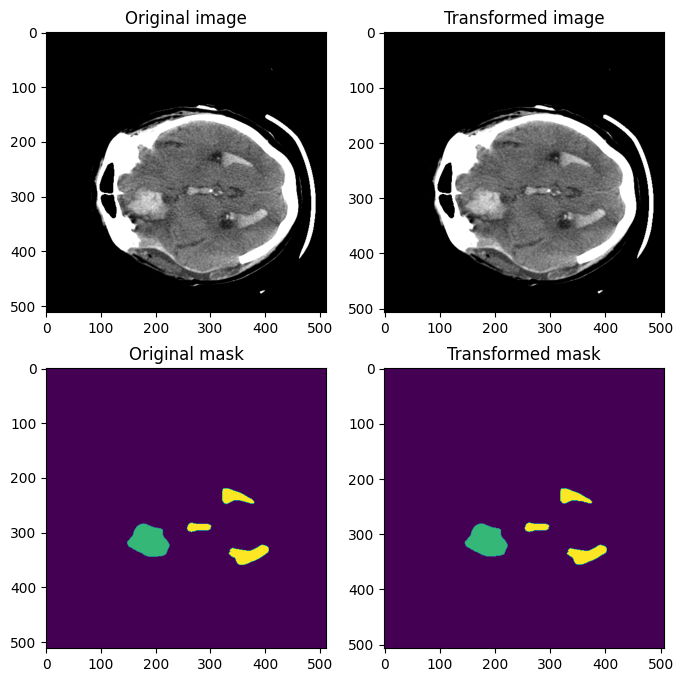

In [6]:
transform = transforms.Spacingd(
    keys=["image", "label"],
    pixdim=(0.5, 0.5, 1),
    mode=["bilinear", "nearest"]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data, ori_idx=20, aug_idx=100)

## Orientation

在医学影像分析中，数据的方向（方向信息、轴顺序）是非常重要的。因为不同数据集（不同医院、不同扫描协议）往往会使用不同的空间方向编码，比如 `(LPS)`、`(RAS)` 等。MONAI 提供了 `Orientationd` 这个变换，用于 **规范化数据的空间方向**，以便后续模型能够处理统一方向的数据。

`Orientationd` 的主要功能是：  

- 将图像（以及标签、掩码等）从任意方向变换为指定的方向编码。  
- 方向编码是医学影像中常用的 3 字母代码（如 `RAS`, `LPS`）。  
- 保证批量训练中不同样本的方向一致，避免模型混淆。

### 使用场景 

- 在处理医学影像（尤其是 3D MRI、CT 数据）时，保证不同来源数据在空间方向上保持一致非常关键。

### 参数解析 

| 参数名                     | 类型                | 说明                                                         |
| -------------------------- | ------------------- | ------------------------------------------------------------ |
| **axcodes**                | 序列(str)           | 目标空间方向编码。例如 `'RAS'` 表示3D方向：(X轴 左/右，Y轴 后/前，Z轴 下/上)。默认支持 `'L'` 和 `'R'`（X轴），`'P'` 和 `'A'`（Y轴），`'I'` 和 `'S'`（Z轴）。 |
| **as\_closest\_canonical** | bool                | 如果为 `True`，则加载图像时会自动选择接近 canonical（标准）坐标系的方向。用于处理不规则方向数据。 |
| **labels**                 | None 或 序列(tuple) | 指定每一维度的起始和结束标签。默认值：`(('L','R'), ('P','A'), ('I','S'))`。 |
| **allow\_missing\_keys**   | bool                | 如果为 `True`，则在指定的 key 不存在时不会抛出异常。默认 `False`。 |
| **lazy**                   | bool                | 是否延迟执行该变换。若为 `True`，变换不会立即执行而是累积。默认 `False`。 |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


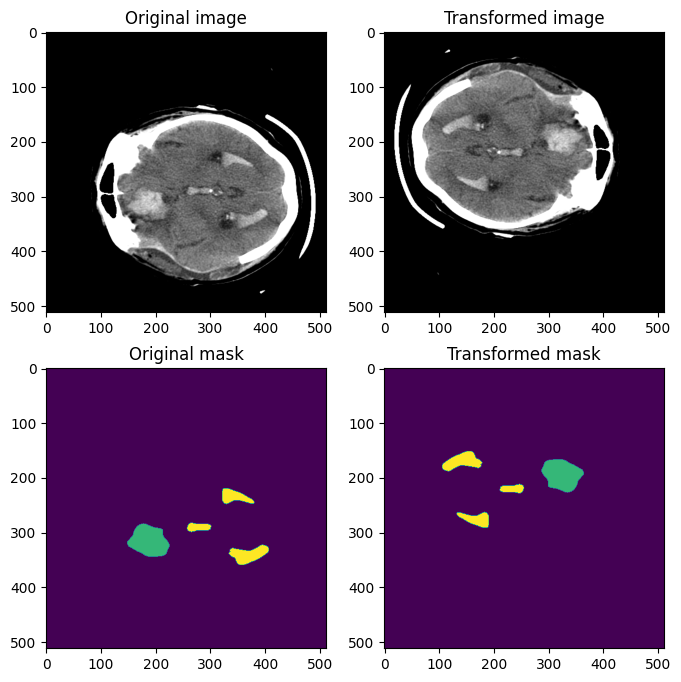

In [10]:
# (Left, Right), (Posterior, Anterior), (Inferior, Superior)
transform = transforms.Orientationd(
    keys=["image", "label"],
    axcodes="RAS"
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandRotate90

`RandRotate90d` 主要用于对医学影像数据进行随机旋转。它会以 90 度为单位对输入图像以及标签进行随机旋转。

### 使用场景 

-   医学影像（CT、MRI、超声等）中的图像和标签同步旋转。

-   增加数据多样性，提高模型泛化能力。

-   对 2D 或 3D 数据都适用，只需调整 `spatial_axes`。

### 参数解析 

| 参数名                   | 类型              | 默认值 | 说明                                                         |
| ------------------------ | ----------------- | ------ | ------------------------------------------------------------ |
| **`keys`**               | List\[str\]       | 必填   | 要应用旋转的数据字段名称（例如 `["image", "label"]`）。参考 `MapTransform`。 |
| **`prob`**               | float             | 0.1    | 旋转的概率。默认值是 0.1，即有 10% 的概率进行旋转。          |
| **`max_k`**              | int               | 3      | 从 `np.random.randint(max_k) + 1` 中随机选取旋转次数（即旋转多少个 90°）。`max_k=3` 表示最多 270°。 |
| **`spatial_axes`**       | Tuple\[int, int\] | (0, 1) | 定义旋转的平面（即旋转发生在哪两个空间轴之间）。默认 (0,1) 表示第一个和第二个维度（通常是 x, y）。 |
| **`allow_missing_keys`** | bool              | False  | 如果为 True，输入数据缺少指定 key 时不会报错，默认 False。   |
| **`lazy`**               | bool              | False  | 指示该转换是否采用延迟执行模式。默认 False。                 |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


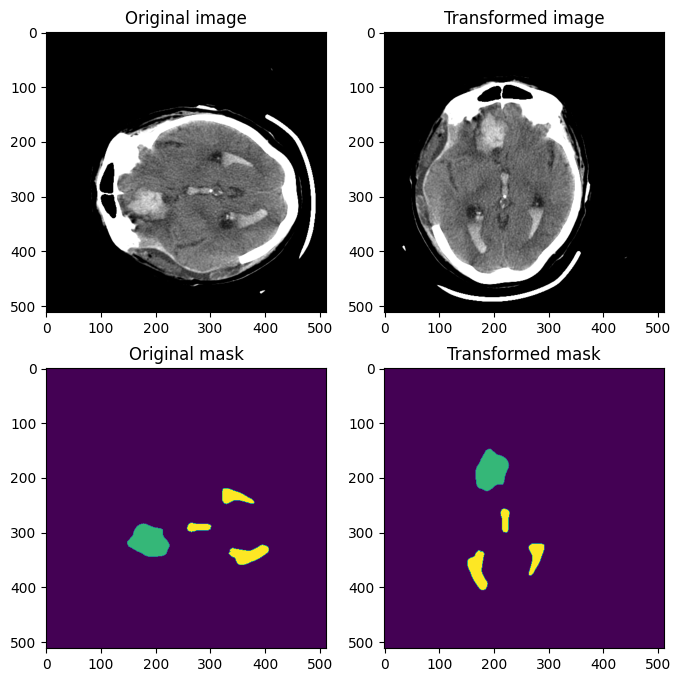

In [12]:
transform = transforms.RandRotate90d(
    keys=["image", "label"],
    prob=1,
    max_k=3,
    spatial_axes=(0, 1)
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## Resize

`Resized` 主要作用是将输入图像（以及标签、蒙版等）缩放到指定的空间大小（spatial size）。  
它使用插值方法对图像进行放缩，以适应模型输入所需的大小，同时可以选择是否对标签采用最近邻插值（避免连续值标签产生模糊）。

### 使用场景 

-   适用于图像和标签的尺寸统一（尤其是在深度学习模型中）。
-   图像尺寸不一致的数据批量处理。  

### 参数解析 

| 参数                      | 类型               | 说明                                                         |
| ------------------------- | ------------------ | ------------------------------------------------------------ |
| **keys**                  | `list`             | 要进行变换的字段名，参考 `monai.transforms.compose.MapTransform`。 |
| **spatial\_size**         | `tuple` 或 `int`   | 指定目标空间大小。如果某些维度值 ≤0，使用原始图像的相应维度。例如：`(32, -1)` 会适应为 `(32, 64)` 如果原图第二维度是64。 |
| **size\_mode**            | `str`              | `"all"` 或 `"longest"`。`"all"` 按 `spatial_size` 缩放所有维度；`"longest"` 只按最长边缩放，保持长宽比（此时 `spatial_size` 必须是单个整数），类似于 `albumentations.LongestMaxSize`。 |
| **mode**                  | `str` 或 `list`    | 插值模式：`"nearest"`, `"nearest-exact"`, `"linear"`, `"bilinear"`, `"bicubic"`, `"trilinear"`, `"area"`，可参考 [PyTorch interpolate](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html)。也可以是与 `keys` 对应的插值模式列表。 |
| **align\_corners**        | `bool` 或 `list`   | 仅在 `linear`、`bilinear`、`bicubic`、`trilinear` 模式下生效，是否对齐角点。也可以是与 `keys` 对应的布尔值或 `None`。 |
| **anti\_aliasing**        | `bool`             | 是否在下采样时使用高斯滤波（防止锯齿伪影），参考 `skimage.transform.resize`。 |
| **anti\_aliasing\_sigma** | `float` 或 `tuple` | 高斯滤波标准差。默认使用 `(s-1)/2`，其中 `s` 是下采样比例（s>1）。如果是上采样（s<1），不会进行抗锯齿。 |
| **dtype**                 | `数据类型`         | 重采样计算的数据类型。默认为 `float32`，也可以继承输入数据类型。 |
| **allow\_missing\_keys**  | `bool`             | 如果指定的 `keys` 不存在，是否忽略而不抛出异常。             |
| **lazy**                  | `bool`             | 是否启用延迟执行。默认为 `False`。适合在某些情况下结合 `Compose` 或 `Randomizable` 使用。 |

image shape: torch.Size([1, 468, 468, 76]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 468, 468, 76]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


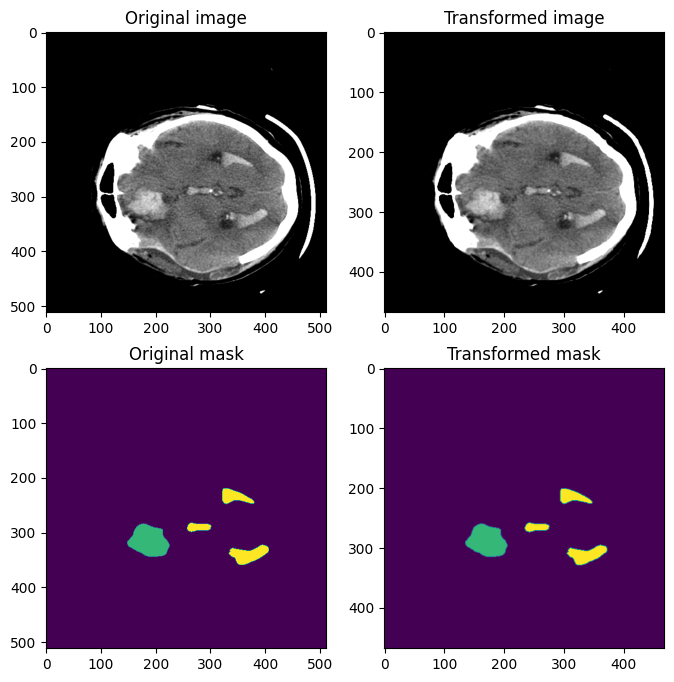

In [13]:
transform = transforms.Resized(
    keys=["image", "label"],
    spatial_size=(468, 468, 76)
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data, ori_idx=20, aug_idx=40)

## RandAffine

`RandAffined` 是一种 **随机仿射变换**（包括旋转、平移、缩放、剪切等）的数据增强方式，用于对医学图像进行增强，提高模型的泛化能力。

### 使用场景 

-   用于医学图像的旋转、平移、缩放和剪切。
-   可通过灵活的参数控制不同程度的空间增强。  

### 参数解析 

| 参数                     | 类型                 | 默认值       | 描述                                                         |
| ------------------------ | -------------------- | ------------ | ------------------------------------------------------------ |
| **`keys`**               | list\[str\]          | –            | 需要应用变换的键（如 `["image", "label"]`）。                |
| **`spatial_size`**       | tuple\[int\] 或 None | None         | 输出空间尺寸。如果为 None 或小于 1，使用输入图像大小。若某维为非正数，则用对应输入图像维度大小替代。 |
| **`prob`**               | float                | 0.1          | 应用随机仿射变换的概率。                                     |
| **`rotate_range`**       | float 或 tuple       | None         | 各维旋转范围（弧度）。可为单值（表示 `[-x,x]`）或 `(min, max)` 对（表示 `[-min,max)`）。 |
| **`shear_range`**        | float 或 tuple       | None         | 剪切范围。格式同 `rotate_range`。对于 3D，为 6 个剪切系数（见下方 affine 矩阵解释）。 |
| **`translate_range`**    | float 或 tuple       | None         | 平移范围（像素或体素）。格式同 `rotate_range`。              |
| **`scale_range`**        | float 或 tuple       | None         | 缩放范围。格式同 `rotate_range`，值为 `[-x, x]`，会加上 `1.0`，即 0 表示不缩放。 |
| **`mode`**               | str 或 int 或 list   | "bilinear"   | 插值模式，支持 `'bilinear'`, `'nearest'` 或 0~5 表示样条插值阶次。可为列表，对每个 `key` 单独设置。 |
| **`padding_mode`**       | str 或 list          | "reflection" | 变换后超出边界的填充方式。支持 `'zeros'`, `'border'`, `'reflection'`。可为列表，匹配 `keys`。 |
| **`cache_grid`**         | bool                 | False        | 是否缓存仿射采样网格（对静态 `spatial_size` 加速）。         |
| **`device`**             | torch.device 或 None | None         | 指定输出张量的设备（如 `"cuda"`）。                          |
| **`allow_missing_keys`** | bool                 | False        | 如果 `keys` 中有缺失，不报错。                               |
| **`lazy`**               | bool                 | False        | 是否启用惰性执行（推迟变换执行）。                           |

image shape: torch.Size([1, 468, 468, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 468, 468, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


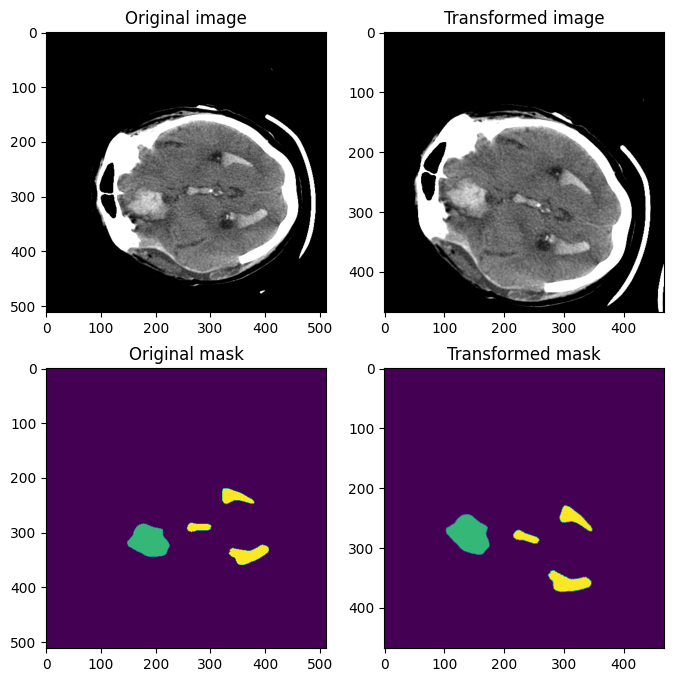

In [14]:
transform = transforms.RandAffined(
    keys=["image", "label"],
    spatial_size=(468, 468, 38),
    prob=1,
    rotate_range=(0, 0, np.pi/2),  # 绕z轴旋转90度
    translate_range=(10, -10, 0)   # 在xy方向偏移
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## Rand3DElastic

`Rand3DElasticd` 是 MONAI 中用于 **三维医学影像**（如CT、MRI）的 **随机弹性形变** 数据增强变换。它可以在训练时引入随机的形变，增强模型的鲁棒性。

### 使用场景 

-   用于医学影像的 **三维弹性形变**。  
-   支持同时变换图像、标签，且保持对齐。

### 参数解析 

| 参数名                   | 类型                                | 说明                                                         | 默认值       |
| ------------------------ | ----------------------------------- | ------------------------------------------------------------ | ------------ |
| **keys**                 | list\[str\]                         | 要进行变换的字段（比如 `["image", "label"]`）。              | 必须指定     |
| **sigma\_range**         | tuple\[float, float\]               | 控制高斯平滑的标准差范围，决定了形变的平滑程度。             | 必须指定     |
| **magnitude\_range**     | tuple\[float, float\]               | 控制形变偏移的范围，决定形变强度。                           | 必须指定     |
| **spatial\_size**        | tuple\[int, int, int\] 或 None      | 输出空间大小 (h, w, d)。支持自动适应，或指定维度，或用 `-1` 表示自动适应该维度。 | None         |
| **prob**                 | float                               | 应用该变换的概率。                                           | 0.1          |
| **rotate\_range**        | float / tuple / tuple\[tuple, ...\] | 随机旋转角度范围（单位弧度），可设置不同维度范围。           | None         |
| **shear\_range**         | float / tuple / tuple\[tuple, ...\] | 随机剪切（shear）范围，用于仿射矩阵。                        | None         |
| **translate\_range**     | float / tuple / tuple\[tuple, ...\] | 随机平移范围，按体素维度设置。                               | None         |
| **scale\_range**         | float / tuple / tuple\[tuple, ...\] | 随机缩放范围。0表示无缩放，1表示缩放因子1。                  | None         |
| **mode**                 | str / int / list                    | 插值方式（"bilinear"、"nearest" 或 0-5 表示 B样条阶数）。可为不同 keys 单独设置。 | "bilinear"   |
| **padding\_mode**        | str / list                          | 插值时的边界填充方式（"zeros"、"border"、"reflection"等），可为不同 keys 单独设置。 | "reflection" |
| **device**               | torch.device 或 None                | 张量处理使用的设备（比如 `"cpu"` 或 `"cuda"`）。             | None         |
| **allow\_missing\_keys** | bool                                | 如果 key 不存在是否忽略而不抛出异常。                        | False        |

image shape: torch.Size([1, 468, 468, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 468, 468, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


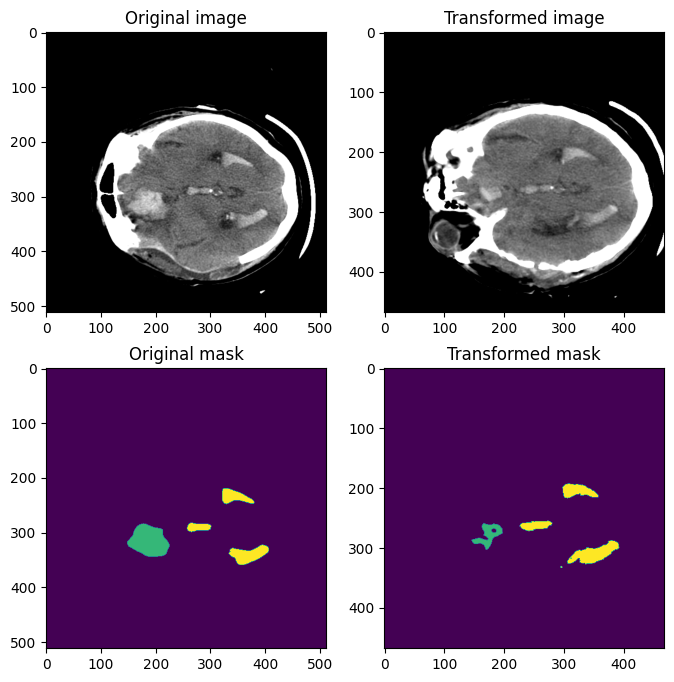

In [15]:
transform = transforms.Rand3DElasticd(
    keys=["image", "label"],
    mode=["bilinear", "nearest"],  # 对image用bilinear, 对label用nearest
    prob=1,
    sigma_range=(5, 7),
    magnitude_range=(50, 100),
    spatial_size=(468, 468, 38),
    translate_range=(10, 10, 0),
    rotate_range=(0.1, 0.1, 0.1),
    scale_range=(0.1, 0.1, 0.1),
    padding_mode="border"
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandFlip

`RandFlipd` 是 MONAI 中用于医学影像处理（尤其是 3D 医学影像）的 **随机翻转** 数据增强操作。它可以在数据加载阶段对图像（以及对应的标签）进行随机翻转，从而提高模型的泛化能力。

### 使用场景 

-   增强数据多样性；

-   避免模型过拟合；

### 参数解析 

| 参数                 | 类型                              | 默认值   | 说明                                                         |
| -------------------- | --------------------------------- | -------- | ------------------------------------------------------------ |
| `keys`               | `Union[str, Sequence[str]]`       | **必填** | 需要进行翻转的字段（如 `"image"` 或 `["image", "label"]`）。 |
| `prob`               | `float`                           | 0.1      | 随机翻转的概率，范围为 \[0,1\]。                             |
| `spatial_axis`       | `Union[int, Sequence[int], None]` | `None`   | 翻转的空间轴（例如 `0`, `1`, `2` 或 `[0,1,2]`）。如果是 `None`，则默认不翻转。 |
| `allow_missing_keys` | `bool`                            | `False`  | 如果为 `True`，则当输入数据中缺少指定 `keys` 时不会报错；如果为 `False`，缺少时会抛出异常。 |
| `lazy`               | `bool`                            | `False`  | 如果为 `True`，该变换会延迟执行（惰性模式），直到真正需要时再进行；默认为 `False`。 |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


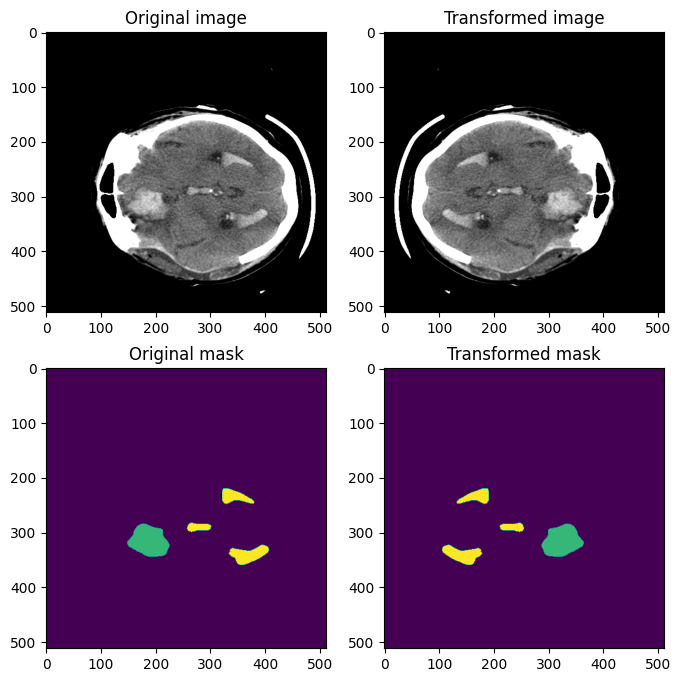

In [16]:
transform = transforms.RandFlipd(
    keys=["image", "label"],
    prob=1,
    spatial_axis=1
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandRotate

`RandRotated` 主要用于对图像（和标签）进行随机旋转，从而增强模型的鲁棒性，特别适用于医学图像分析任务（如CT、MRI、超声等）。

### 使用场景 

-   增强数据多样性；

-   避免模型过拟合；

### 参数解析 

| 参数名称             | 含义                                                         |
| -------------------- | ------------------------------------------------------------ |
| `keys`               | 需要进行旋转的字段名（通常是图像、标签等）。                 |
| `range_x`            | 沿第一、二轴（通常是 XY 平面）旋转的角度范围（弧度）。单个数表示从 `(-range_x, range_x)` 中均匀采样。 |
| `range_y`            | 沿第一、三轴（通常是 XZ 平面）旋转的角度范围（弧度），仅对 **3D 数据**有效。单个数表示从 `(-range_y, range_y)` 中均匀采样。 |
| `range_z`            | 沿第二、三轴（通常是 YZ 平面）旋转的角度范围（弧度），仅对 **3D 数据**有效。单个数表示从 `(-range_z, range_z)` 中均匀采样。 |
| `prob`               | 应用旋转的概率（0~1）。                                      |
| `keep_size`          | 若 `True`，输出形状与输入相同（旋转后裁剪/填充）；若 `False`，则输出包含整个输入。默认为 `True`。 |
| `mode`               | 插值模式（`"bilinear"` 或 `"nearest"`，可为序列，指定不同 key 使用的插值）。用于 PyTorch 中 `grid_sample`，推荐连续图像用 bilinear，标签图用 nearest。 |
| `padding_mode`       | 超出边界时的填充方式（`"zeros"`, `"border"`, `"reflection"`，可为序列）。 |
| `align_corners`      | 控制插值计算中角点对齐（布尔值或序列）。参考 [PyTorch 文档](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html)。 |
| `dtype`              | 计算中使用的数据类型（默认为 `float64`，确保高精度；如果为 `None` 则使用输入数据类型；也可为序列）。最终输出类型为 `float32` 以兼容。 |
| `allow_missing_keys` | 如果指定 key 在数据中缺失，是否跳过而不报错（布尔值）。      |
| `lazy`               | 是否延迟执行变换（布尔值）。                                 |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


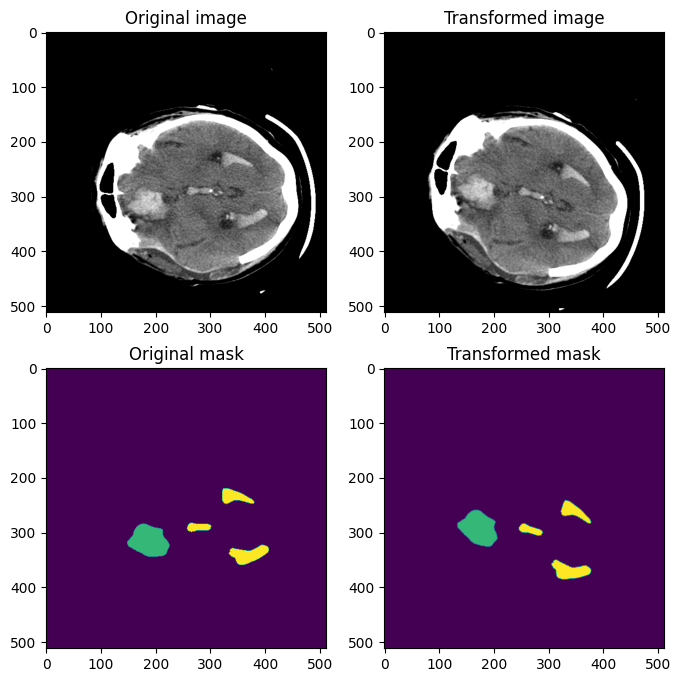

In [22]:
transform = transforms.RandRotated(
    keys=["image", "label"],
    range_z=np.pi/2,
    prob=1,
    keep_size=True
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandZoom

`RandZoomd` 用于对图像进行 **随机缩放（zoom in/out）** 的一类数据增强方法。它特别适合医学图像（如 CT、MRI）的预处理和训练过程，能够提升模型的泛化能力。

### 使用场景 

-   增强数据多样性；

-   避免模型过拟合；

### 参数解析 

| 参数                     | 说明                                                         |
| ------------------------ | ------------------------------------------------------------ |
| **`keys`**               | 要选择进行变换的键。                                         |
| **`prob`**               | 应用缩放的概率。                                             |
| **`min_zoom`**           | 最小缩放因子。可以是浮点数或与图像维度大小相同的序列：<br/>\- 如果是浮点数，则在 `[min_zoom, max_zoom]` 中随机选择一个因子，应用到所有空间维度，保持空间形状比例。<br/>\- 如果是序列，应该包含每个空间轴的最小值。对于 3D 数据，如果提供 2 个值，则第一个值会用于 H 和 W，以保持缩放比例。 |
| **`max_zoom`**           | 最大缩放因子。与 `min_zoom` 类似。                           |
| **`mode`**               | 插值模式（参考 PyTorch 的 `interpolate`）：<br/>可选：`"nearest"`，`"nearest-exact"`，`"linear"`，`"bilinear"`，`"bicubic"`，`"trilinear"`，`"area"`。<br/>可以是一个字符串或一个序列（与 `keys` 对应）。： |
| **`padding_mode`**       | 缩放后填充模式：<br/>\- 对于 numpy 数组：`"constant"`，`"edge"`，`"linear_ramp"`，`"maximum"`，`"mean"`，`"median"`，`"minimum"`，`"reflect"`，`"symmetric"`，`"wrap"`，`"empty"`。<br/>\- 对于 PyTorch Tensor：`"constant"`，`"reflect"`，`"replicate"`，`"circular"`。<br/>\- 也可传入自定义函数。默认：`"edge"`。 |
| **`align_corners`**      | 仅在插值模式为 `'linear'`, `'bilinear'`, `'bicubic'`, `'trilinear'` 时有效。可以是单个布尔值，也可以是一个布尔值序列（与 `keys` 对应）。 |
| **`dtype`**              | 进行重采样计算时的数据类型。默认：`float32`。如果为 `None`，则使用输入数据的类型。 |
| **`keep_size`**          | 是否保持原始尺寸（必要时通过填充）。默认：`True`。           |
| **`allow_missing_keys`** | 如果某个 key 不存在，是否不抛出异常。                        |
| **`lazy`**               | 指示该变换是否延迟执行。默认：`False`。                      |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


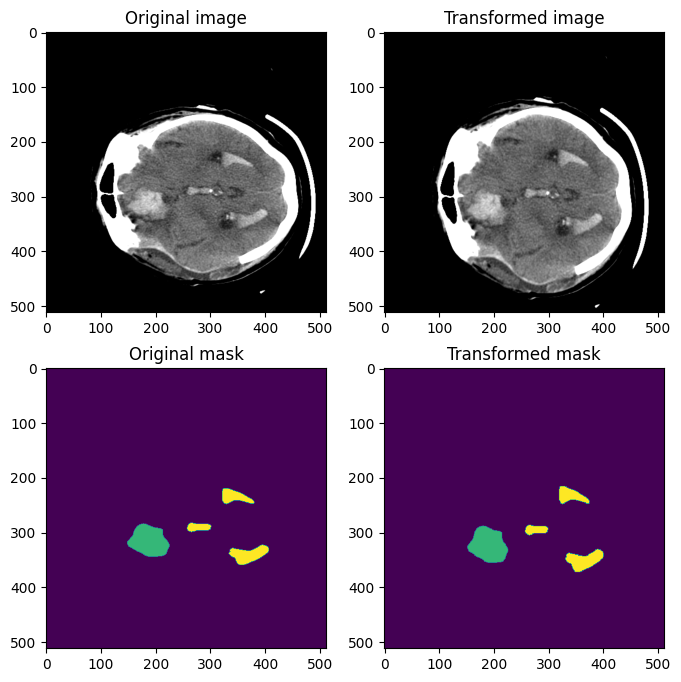

In [25]:
transform = transforms.RandZoomd(
    keys=["image", "label"],
    prob=1,
    min_zoom=(0.6, 0.6, 1),
    max_zoom=(1.4, 1.4, 1),
    keep_size=True,
    mode=["bilinear", "nearest"]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandGridDistortion

`RandGridDistortiond` 通过在图像上生成网格，将网格点随机移动，然后使用插值对图像进行扭曲。常用于医学图像增强。

-   将图像分为一个规则的网格 (由 `num_cells` 参数决定)。

-   对每个网格点（除边界外）随机移动，最大位移由 `distort_limit` 参数控制。

-   对整个图像进行插值，生成扭曲后的图像。

-   这种方法可以模拟图像采集中的几何畸变，使模型更加健壮。

### 使用场景 

-   增强数据多样性；

-   避免模型过拟合；

### 参数解析 

| 参数                     | 说明                                                         | 默认值        |
| ------------------------ | ------------------------------------------------------------ | ------------- |
| **`keys`**               | 要应用变换的字段名                                           | 必填          |
| **`num_cells`**          | 每个维度划分的网格单元数                                     | 必填          |
| **`prob`**               | 进行随机网格畸变的概率                                       | 0.1           |
| **`distort_limit`**      | 随机偏移范围。如果是单值，取自 (-distort\_limit, distort\_limit)；可以是范围或 per-dimension | (-0.03, 0.03) |
| **`mode`**               | 插值模式。可以是：字符串: "bilinear"、"nearest"整数 0-5：表示样条插值阶数（使用 numpy/cup 后端）也可以是序列，对应 `keys`详见 [torch.nn.functional.grid\_sample](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) 和 [scipy.ndimage.map\_coordinates](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html) | "bilinear"    |
| **`padding_mode`**       | 填充模式，用于超出网格边界的取值。可选：PyTorch: "zeros"、"border"、"reflection";NumPy/cupy: "reflect"、"grid-mirror"、"constant"、"grid-constant"、"nearest"、"mirror"、"grid-wrap"、"wrap"也可以是序列，对应 `keys` | "border"      |
| **`device`**             | 分配张量的设备                                               | None          |
| **`allow_missing_keys`** | 如果某些 key 缺失，是否不抛出异常                            | False         |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


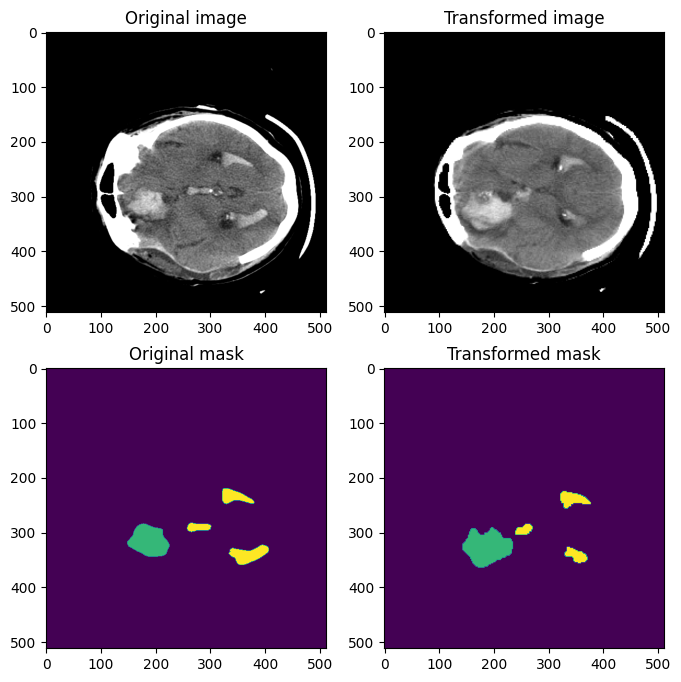

In [27]:
transform = transforms.RandGridDistortiond(
    keys=["image", "label"],
    num_cells=[256, 256, 4],
    prob=1,
    distort_limit=0.3,
    mode=["bilinear", "nearest"]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)